**Set up notebook:**

In [ ]:
%matplotlib notebook

In [1]:
#Configure Google Drive
from google.colab import drive
drive.mount('/content/drive')

#Path to dataset folder
data_folder = '/content/drive/My Drive/MA/'

Mounted at /content/drive


In [13]:
#Import required libraries for this notebook
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from keras.models import Sequential
from keras.models import model_from_json, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM, Input
import matplotlib.pyplot as plt
from google.colab import files
import seaborn as sns

**Load dataset:**

In [11]:
#Read data
signals = 'wind-farm-1-signals-training.csv'
signals_test = 'wind-farm-1-signals-testing.csv'
all_data = pd.concat([pd.read_csv(data_folder + signals, delimiter=';'), pd.read_csv(data_folder + signals_test, delimiter=';')], ignore_index=True)

#Filter T_09 data out
wtg_data = all_data[all_data.Turbine_ID == 'T09'].reset_index().drop(columns=['index'])

wtg_data['Timestamp'] = pd.to_datetime(wtg_data['Timestamp'])
wtg_data.set_index('Timestamp', inplace=True)
wtg_data = wtg_data[wtg_data['Grd_Prod_Pwr_Avg'] > 0]
print(wtg_data.dtypes)
wtg_data.head()

Turbine_ID                object
Gen_RPM_Max              float64
Gen_RPM_Min              float64
Gen_RPM_Avg              float64
Gen_RPM_Std              float64
                          ...   
Grd_Prod_PsbleCap_Max    float64
Grd_Prod_PsbleCap_Min    float64
Grd_Prod_PsbleCap_Std    float64
Gen_Bear2_Temp_Avg         int64
Nac_Direction_Avg        float64
Length: 82, dtype: object


,Turbine_ID,Gen_RPM_Max,Gen_RPM_Min,Gen_RPM_Avg,Gen_RPM_Std,Gen_Bear_Temp_Avg,Gen_Phase1_Temp_Avg,Gen_Phase2_Temp_Avg,Gen_Phase3_Temp_Avg,Hyd_Oil_Temp_Avg,Gear_Oil_Temp_Avg,Gear_Bear_Temp_Avg,Nac_Temp_Avg,Rtr_RPM_Max,Rtr_RPM_Min,Rtr_RPM_Avg,Amb_WindSpeed_Max,Amb_WindSpeed_Min,Amb_WindSpeed_Avg,Amb_WindSpeed_Std,Amb_WindDir_Relative_Avg,Amb_WindDir_Abs_Avg,Amb_Temp_Avg,Prod_LatestAvg_ActPwrGen0,Prod_LatestAvg_ActPwrGen1,Prod_LatestAvg_ActPwrGen2,Prod_LatestAvg_TotActPwr,Prod_LatestAvg_ReactPwrGen0,Prod_LatestAvg_ReactPwrGen1,Prod_LatestAvg_ReactPwrGen2,Prod_LatestAvg_TotReactPwr,HVTrafo_Phase1_Temp_Avg,HVTrafo_Phase2_Temp_Avg,HVTrafo_Phase3_Temp_Avg,Grd_InverterPhase1_Temp_Avg,Cont_Top_Temp_Avg,Cont_Hub_Temp_Avg,Cont_VCP_Temp_Avg,Gen_SlipRing_Temp_Avg,Spin_Temp_Avg,...,Blds_PitchAngle_Avg,Blds_PitchAngle_Std,Cont_VCP_ChokcoilTemp_Avg,Grd_RtrInvPhase1_Temp_Avg,Grd_RtrInvPhase2_Temp_Avg,Grd_RtrInvPhase3_Temp_Avg,Cont_VCP_WtrTemp_Avg,Grd_Prod_Pwr_Avg,Grd_Prod_CosPhi_Avg,Grd_Prod_Freq_Avg,Grd_Prod_VoltPhse1_Avg,Grd_Prod_VoltPhse2_Avg,Grd_Prod_VoltPhse3_Avg,Grd_Prod_CurPhse1_Avg,Grd_Prod_CurPhse2_Avg,Grd_Prod_CurPhse3_Avg,Grd_Prod_Pwr_Max,Grd_Prod_Pwr_Min,Grd_Busbar_Temp_Avg,Rtr_RPM_Std,Amb_WindSpeed_Est_Avg,Grd_Prod_Pwr_Std,Grd_Prod_ReactPwr_Avg,Grd_Prod_ReactPwr_Max,Grd_Prod_ReactPwr_Min,Grd_Prod_ReactPwr_Std,Grd_Prod_PsblePwr_Avg,Grd_Prod_PsblePwr_Max,Grd_Prod_PsblePwr_Min,Grd_Prod_PsblePwr_Std,Grd_Prod_PsbleInd_Avg,Grd_Prod_PsbleInd_Max,Grd_Prod_PsbleInd_Min,Grd_Prod_PsbleInd_Std,Grd_Prod_PsbleCap_Avg,Grd_Prod_PsbleCap_Max,Grd_Prod_PsbleCap_Min,Grd_Prod_PsbleCap_Std,Gen_Bear2_Temp_Avg,Nac_Direction_Avg
Timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00+00:00,T09,1376.7,1234.3,1272.0,24.7,40.0,58,57,58,44,43,48,29,12.2,10.9,11.2,9.9,1.8,5.2,0.9,6.1,220.1,18,0,33173.0,0,33173.0,0,-13513,0,-13513,68,72,64,39,38,27,39,26,19,...,-1.3,0.5,93,39,41,40,38,198.4,0.9,50.0,402.0,399.5,399.1,161.5,198.3,178.0,349.0,46.0,36,0.2,5.1,61.0,-81.1,-72.7,-100.1,5.0,198.1,356.7,45.7,61.5,-861.6,-224.5,-1000.0,185.5,861.6,1000.0,224.5,185.5,33,214.0
2016-01-01 00:10:00+00:00,T09,1485.0,1239.7,1321.4,50.4,40.0,58,57,58,44,43,48,29,13.1,10.9,11.7,9.1,2.0,5.7,1.1,4.7,218.7,18,0,38381.0,0,38381.0,0,-15366,0,-15366,68,72,64,39,38,27,39,26,19,...,-1.6,0.6,93,40,41,41,38,231.1,0.9,50.0,401.8,399.5,399.0,190.5,228.4,207.9,431.3,60.7,36,0.4,5.3,86.4,-92.1,-76.7,-102.1,5.7,231.3,435.5,59.9,86.4,-871.4,-293.3,-1000.0,227.4,871.4,1000.0,293.3,227.4,33,214.0
2016-01-01 00:20:00+00:00,T09,1441.0,1274.6,1363.4,31.0,40.0,58,57,58,44,44,49,29,12.8,11.2,12.0,11.2,1.4,6.2,0.8,2.7,216.7,18,0,52055.0,0,52055.0,0,-15709,0,-15709,68,73,64,39,38,27,39,26,19,...,-1.9,0.2,93,40,41,41,38,312.3,1.0,50.0,401.2,398.8,398.2,249.2,290.0,274.7,441.9,191.6,37,0.3,5.8,44.2,-94.3,-33.6,-108.3,13.0,312.4,450.2,184.7,45.1,-999.7,-904.9,-1000.0,4.2,999.7,1000.0,904.9,4.2,33,214.0
2016-01-01 00:30:00+00:00,T09,1549.4,1266.5,1379.7,76.8,41.0,59,58,59,44,44,50,29,13.7,11.2,12.2,10.1,2.4,6.3,1.0,-16.1,197.9,18,0,66365.0,0,66365.0,0,-16444,0,-16444,68,73,65,39,38,27,39,26,19,...,-1.9,0.3,93,40,41,41,38,398.8,1.0,50.0,400.7,398.5,398.1,319.2,360.3,346.7,618.5,231.1,37,0.7,6.2,86.4,-98.7,-88.4,-105.5,3.4,398.8,630.0,214.5,86.3,-1000.0,-1000.0,-1000.0,0.0,1000.0,1000.0,1000.0,0.0,33,214.0
2016-01-01 00:40:00+00:00,T09,1536.5,1337.1,1426.9,42.0,41.0,59,58,59,44,45,51,29,13.6,11.8,12.6,11.7,1.9,6.6,0.9,3.2,217.2,18,0,60980.0,0,60980.0,0,-16344,0,-16344,68,73,65,39,38,27,39,26,19,...,-2.0,0.1,93,40,41,41,38,366.3,1.0,50.0,400.0,397.8,397.4,294.4,335.2,319.0,541.1,169.9,37,0.4,6.1,63.5,-98.1,-92.0,-106.3,3.7,366.5,544.6,149.2,64.5,-998.9,-730.8,-1000.0,13.9,998.9,1000.0,730.8,13.9,34,214.0


In [ ]:
wtg_data.tail()

,Turbine_ID,Timestamp,Gen_RPM_Max,Gen_RPM_Min,Gen_RPM_Avg,Gen_RPM_Std,Gen_Bear_Temp_Avg,Gen_Phase1_Temp_Avg,Gen_Phase2_Temp_Avg,Gen_Phase3_Temp_Avg,Hyd_Oil_Temp_Avg,Gear_Oil_Temp_Avg,Gear_Bear_Temp_Avg,Nac_Temp_Avg,Rtr_RPM_Max,Rtr_RPM_Min,Rtr_RPM_Avg,Amb_WindSpeed_Max,Amb_WindSpeed_Min,Amb_WindSpeed_Avg,Amb_WindSpeed_Std,Amb_WindDir_Relative_Avg,Amb_WindDir_Abs_Avg,Amb_Temp_Avg,Prod_LatestAvg_ActPwrGen0,Prod_LatestAvg_ActPwrGen1,Prod_LatestAvg_ActPwrGen2,Prod_LatestAvg_TotActPwr,Prod_LatestAvg_ReactPwrGen0,Prod_LatestAvg_ReactPwrGen1,Prod_LatestAvg_ReactPwrGen2,Prod_LatestAvg_TotReactPwr,HVTrafo_Phase1_Temp_Avg,HVTrafo_Phase2_Temp_Avg,HVTrafo_Phase3_Temp_Avg,Grd_InverterPhase1_Temp_Avg,Cont_Top_Temp_Avg,Cont_Hub_Temp_Avg,Cont_VCP_Temp_Avg,Gen_SlipRing_Temp_Avg,...,Blds_PitchAngle_Avg,Blds_PitchAngle_Std,Cont_VCP_ChokcoilTemp_Avg,Grd_RtrInvPhase1_Temp_Avg,Grd_RtrInvPhase2_Temp_Avg,Grd_RtrInvPhase3_Temp_Avg,Cont_VCP_WtrTemp_Avg,Grd_Prod_Pwr_Avg,Grd_Prod_CosPhi_Avg,Grd_Prod_Freq_Avg,Grd_Prod_VoltPhse1_Avg,Grd_Prod_VoltPhse2_Avg,Grd_Prod_VoltPhse3_Avg,Grd_Prod_CurPhse1_Avg,Grd_Prod_CurPhse2_Avg,Grd_Prod_CurPhse3_Avg,Grd_Prod_Pwr_Max,Grd_Prod_Pwr_Min,Grd_Busbar_Temp_Avg,Rtr_RPM_Std,Amb_WindSpeed_Est_Avg,Grd_Prod_Pwr_Std,Grd_Prod_ReactPwr_Avg,Grd_Prod_ReactPwr_Max,Grd_Prod_ReactPwr_Min,Grd_Prod_ReactPwr_Std,Grd_Prod_PsblePwr_Avg,Grd_Prod_PsblePwr_Max,Grd_Prod_PsblePwr_Min,Grd_Prod_PsblePwr_Std,Grd_Prod_PsbleInd_Avg,Grd_Prod_PsbleInd_Max,Grd_Prod_PsbleInd_Min,Grd_Prod_PsbleInd_Std,Grd_Prod_PsbleCap_Avg,Grd_Prod_PsbleCap_Max,Grd_Prod_PsbleCap_Min,Grd_Prod_PsbleCap_Std,Gen_Bear2_Temp_Avg,Nac_Direction_Avg
104638,T09,2017-12-31 23:10:00+00:00,1513.6,1241.0,1361.0,91.5,39.0,61,60,61,45,48,53,26,13.4,11.0,12.0,8.0,4.0,5.9,1.0,4.0,323.9,16,0,64350.0,0,64350.0,0,-20799,0,-20799,68,69,63,38,36,27,40,24,...,-1.7,0.5,73,40,41,41,38,385.9,0.9,50.0,402.1,399.3,399.1,316.0,358.0,341.0,606.6,158.6,35,0.8,6.2,123.4,-124.7,-110.9,-138.0,6.7,385.5,623.0,149.8,123.7,-991.8,-734.1,-1000.0,32.6,991.8,1000.0,734.1,32.6,32,319.9
104639,T09,2017-12-31 23:20:00+00:00,1283.1,1233.6,1252.4,9.2,39.0,61,59,61,45,47,51,26,11.3,10.9,11.1,6.6,3.5,5.1,0.6,4.8,326.1,16,0,40330.0,0,40330.0,0,-18728,0,-18728,68,69,63,39,36,27,39,24,...,-1.2,0.4,73,40,41,40,38,241.5,0.9,50.0,399.2,396.5,396.1,204.0,242.0,224.0,342.1,103.4,35,0.1,5.4,60.0,-112.3,-93.0,-120.2,6.4,240.8,347.3,90.9,60.4,-941.4,-445.2,-1000.0,108.9,941.4,1000.0,445.2,108.9,32,321.3
104640,T09,2017-12-31 23:30:00+00:00,1259.7,1239.3,1250.2,3.9,39.0,60,59,61,45,47,50,26,11.1,10.9,11.0,6.3,3.4,4.9,0.5,0.6,330.0,15,0,30195.0,0,30195.0,0,-15026,0,-15026,68,69,63,39,36,26,39,24,...,-1.0,0.3,73,40,41,40,38,181.2,0.9,50.0,398.7,395.9,395.2,151.0,189.0,171.0,281.4,65.7,35,0.0,5.1,46.4,-90.1,-81.9,-96.0,3.1,181.6,288.8,61.3,46.7,-846.3,-300.3,-1000.0,178.8,846.3,1000.0,300.3,178.8,32,329.5
104641,T09,2017-12-31 23:40:00+00:00,1279.2,1241.8,1253.0,6.7,39.0,60,59,60,45,47,50,26,11.3,11.0,11.1,6.5,4.0,5.4,0.4,5.3,334.9,15,0,45087.0,0,45087.0,0,-15902,0,-15902,68,69,63,39,36,26,39,24,...,-1.6,0.3,73,40,41,41,38,270.6,0.9,50.0,398.8,396.0,395.6,220.0,257.0,243.0,338.2,200.2,35,0.1,5.6,36.2,-95.4,-87.9,-100.0,2.6,270.8,344.4,196.8,36.3,-999.6,-964.1,-1000.0,2.8,999.6,1000.0,964.1,2.8,32,329.6
104642,T09,2017-12-31 23:50:00+00:00,1258.3,1239.7,1249.5,3.1,39.0,60,58,60,45,46,50,26,11.1,10.9,11.0,6.4,3.5,5.2,0.4,0.9,340.6,15,0,37064.0,0,37064.0,0,-16120,0,-16120,68,69,63,39,36,26,39,23,...,-1.4,0.3,73,40,41,40,38,222.1,0.9,50.0,398.7,396.0,395.5,184.0,221.0,204.0,302.6,84.8,35,0.0,5.3,40.8,-96.7,-87.8,-103.0,4.1,221.6,309.1,76.0,41.4,-955.8,-372.9,-1000.0,119.2,955.8,1000.0,372.9,119.2,32,339.7


In [ ]:
#Amb_WindSpeed_Avg vs Amb_WindSpeed_Est_Avg?
#Correlation before or after Normalization?

In [ ]:
#====================================================================================================================================================

**Set up functions to implement ML pipeline**

In [3]:
def get_train_test_data(dataset: pd.DataFrame, train_month_start, train_year_start, train_month_end, train_year_end,
                        test_month_start, test_year_start, test_month_end, test_year_end):
  
  train_data = dataset[((dataset.index.month >= train_month_start) & (dataset.index.year == train_year_start)) & ((dataset.index.month <= train_month_end) & (dataset.index.year == train_year_end))]

  test_data = dataset[((dataset.index.month >= test_month_start) & (dataset.index.year == test_year_start)) & ((dataset.index.month <= test_month_end) & (dataset.index.year == test_year_end))]

  return train_data, test_data

In [4]:
def get_X_Y(dataset: pd.DataFrame, y_column):
  #Drop rows with NaN values
  XY = dataset.dropna()
  #Split data to X and Y
  X = XY.drop(y_column, axis=1)
  Y = XY[[y_column]]

  return X,Y

In [5]:
def normalize_X_Y_train(X: pd.DataFrame, Y: pd.DataFrame):
  scaler_input = MinMaxScaler(feature_range=(0, 1))
  scaler_input = scaler_input.fit(X)

  scaler_target = MinMaxScaler(feature_range=(0, 1))
  scaler_target = scaler_target.fit(Y)

  X_normalized = pd.DataFrame(scaler_input.transform(X), columns=X.columns, index=X.index)
  Y_normalized = pd.DataFrame(scaler_target.transform(Y), columns=Y.columns, index= Y.index)

  return X_normalized, Y_normalized, scaler_input, scaler_target

In [6]:
def normalize_X_Y_test(X: pd.DataFrame, Y: pd.DataFrame, scaler_input, scaler_target):
  X_normalized = pd.DataFrame(scaler_input.transform(X), columns=X.columns, index=X.index)
  Y_normalized = pd.DataFrame(scaler_target.transform(Y), columns=Y.columns, index= Y.index)

  return X_normalized, Y_normalized

In [7]:
def get_trained_MLP(x: pd.DataFrame, y: pd.DataFrame, model=None, dense_1_shape=32, dense_2_shape=16, epochs=10, batch_size=100, verbose=2):
  #Train model further
  if model:
    model.fit(x, y, epochs=epochs, batch_size = batch_size, verbose = verbose, shuffle=False)
    return model

  #Otherwise, create new model
  model = Sequential([
            Input(x.shape[1]),
            Dense(dense_1_shape),
            Dropout(0.3),
            Dense(dense_2_shape),
            Dropout(0.3),
            Dense(y.shape[1])
        ])
  model.summary()

  #Compile model
  model.compile(loss='mean_squared_error', optimizer='adam')

  #Train model
  model.fit(x, y, epochs=epochs, batch_size = batch_size, verbose = verbose, shuffle=False)

  return model

In [36]:
def plot_predicted_vs_true(predictions: pd.DataFrame, ground_truth: pd.DataFrame, y_column):

  fig, ax = plt.subplots(figsize=(25,7))
  ax.plot(ground_truth.index, predictions[y_column] - ground_truth[y_column], color = 'red')
  #ax.plot(predictions.index, predictions[y_column], color = 'blue')

  ax.grid(True)

  #ax.legend(['Ground Truth', 'Simulation'])
  ax.set_xlabel('Timestamp')
  ax.set_ylabel('Generator Bearing Temp [0C]')

In [39]:
def implement_pipeline(dataset: pd.DataFrame, train_month_start, train_year_start, train_month_end, train_year_end,
                        test_month_start, test_year_start, test_month_end, test_year_end, y_column, features=None,
                       dense_1_shape=32, dense_2_shape=16, epochs=10, batch_size=100, verbose=2, return_option=1, model=None):
  if features:
    dataset = dataset[features]

  #Split dataset to training and test
  train_data, test_data = get_train_test_data(dataset, train_month_start, train_year_start, train_month_end, train_year_end,
                        test_month_start, test_year_start, test_month_end, test_year_end)
  
  #X-Y split
  X_train, Y_train = get_X_Y(train_data, y_column)
  X_test, Y_test = get_X_Y(test_data, y_column)

  #Normalize data
  x_train, y_train, scaler_input, scaler_target = normalize_X_Y_train(X_train, Y_train)

  #Train model
  print('Training model...')
  model = get_trained_MLP(x_train, y_train, model, dense_1_shape, dense_2_shape, epochs, batch_size, verbose)

  #Normalize test data and evaluate model
  x_test, y_test = normalize_X_Y_test(X_test, Y_test, scaler_input, scaler_target)
  print('Evaluating model...')
  model.evaluate(x_test, y_test)

  #Plot predictions vs ground truth
  print()
  predictions = pd.DataFrame(scaler_target.inverse_transform(model.predict(x_test)), columns=Y_test.columns, index=x_test.index)
  plot_predicted_vs_true(pd.DataFrame(scaler_target.inverse_transform(model.predict(x_train)), columns=Y_train.columns, index=x_train.index), Y_train, y_column)
  plot_predicted_vs_true(predictions, Y_test, y_column)

  if return_option == 1:
    return Y_test, predictions


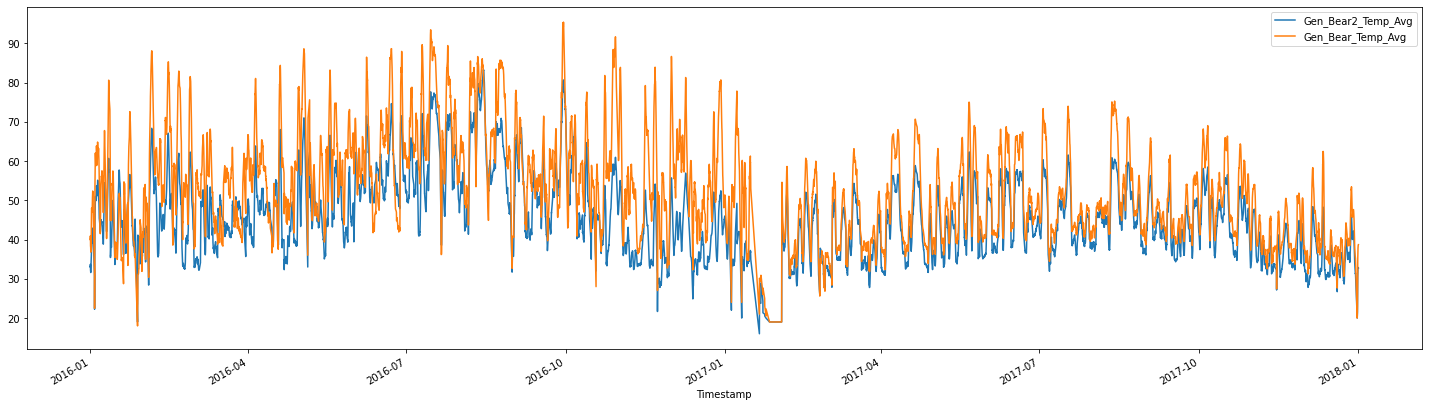

In [49]:
wtg_data[['Gen_Bear2_Temp_Avg', 'Gen_Bear_Temp_Avg']].rolling('D').mean().plot(figsize=(25,7))

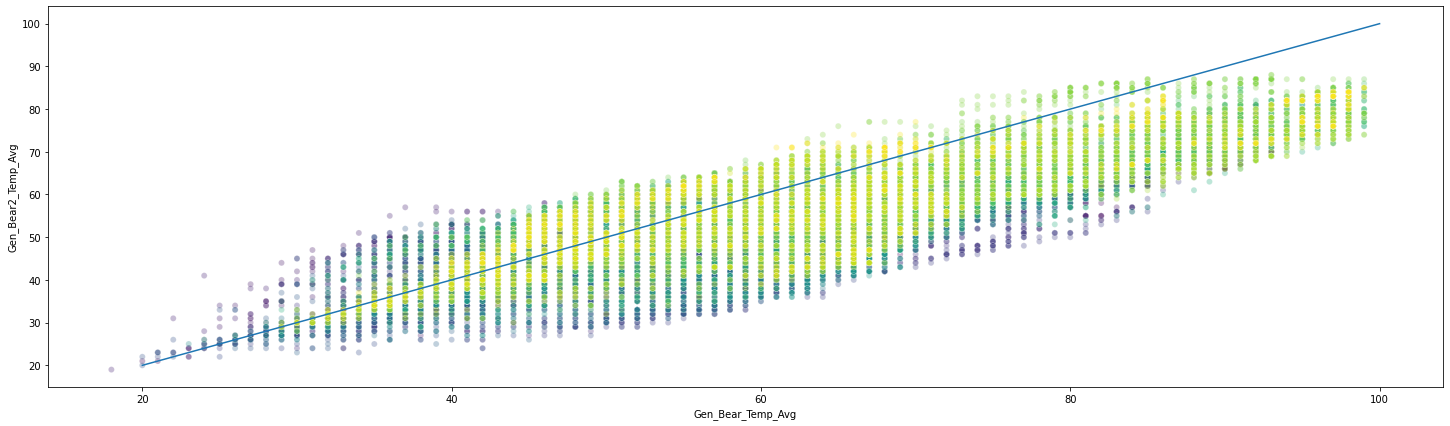

In [63]:
plt.figure(figsize=(25,7))
sns.scatterplot(x='Gen_Bear_Temp_Avg', y='Gen_Bear2_Temp_Avg', data=wtg_data.loc[:'2016-9'], c=wtg_data.loc[:'2016-9'].reset_index().index, alpha=0.3)
sns.lineplot(x=[20,100], y=[20,100])

In [ ]:
#====================================================================================================================================================

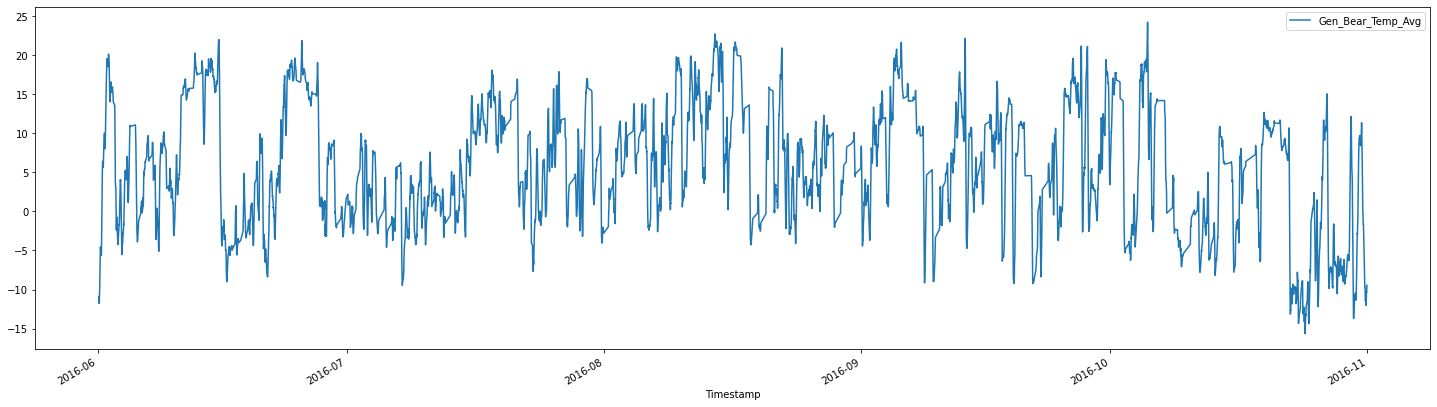

In [69]:
(predictions_1_1 - Y_test_1_1).rolling(18).mean().plot(figsize=(25,7))

In [10]:
y_column = 'Gen_Bear_Temp_Avg'

**Batch 1:** Train between Jan and May, Test between June and *October*

Training model...
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 32)                192       
                                                                 
 dropout_18 (Dropout)        (None, 32)                0         
                                                                 
 dense_28 (Dense)            (None, 16)                528       
                                                                 
 dropout_19 (Dropout)        (None, 16)                0         
                                                                 
 dense_29 (Dense)            (None, 1)                 17        
                                                                 
Total params: 737
Trainable params: 737
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
142/142 - 1s - loss: 0.1472

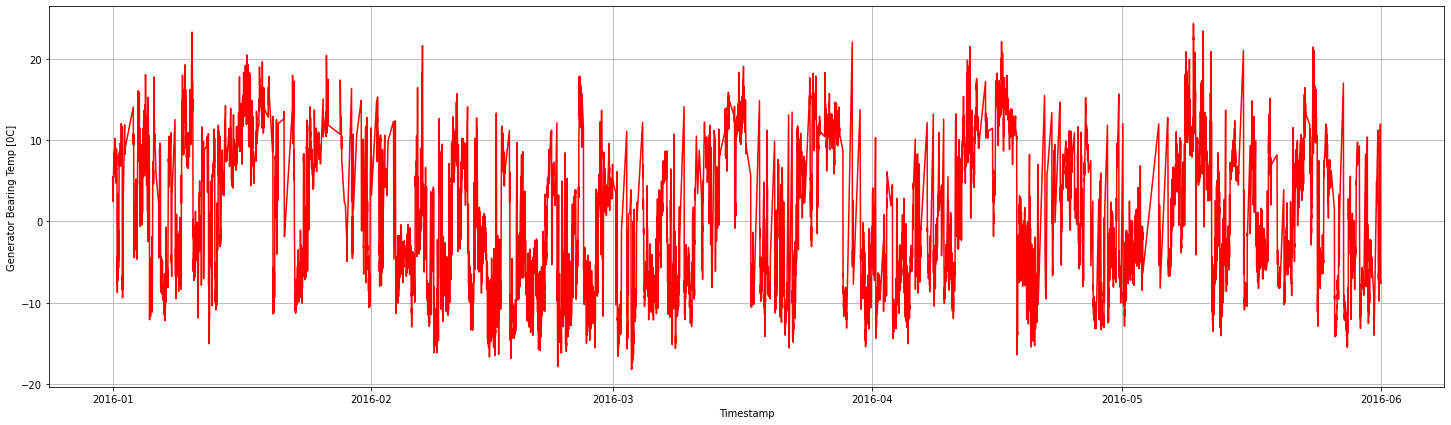

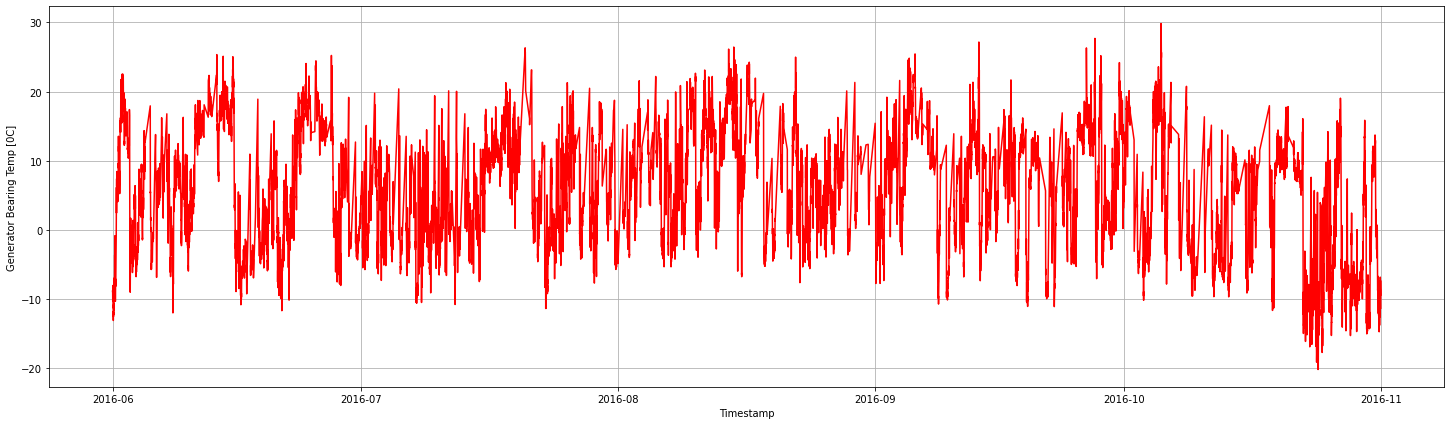

In [67]:
#Feature selection based on causality
features = ['Nac_Temp_Avg', 'Amb_Temp_Avg', 'Gen_RPM_Avg',
                     'Grd_Prod_Pwr_Avg','Gen_Bear2_Temp_Avg', 'Gen_Bear_Temp_Avg']

Y_test_1_1, predictions_1_1 = implement_pipeline(wtg_data, train_month_start=1, train_year_start=2016, train_month_end=5, train_year_end=2016,
                        test_month_start=6, test_year_start=2016, test_month_end=10, test_year_end=2016, y_column = y_column, features=features, epochs=20);

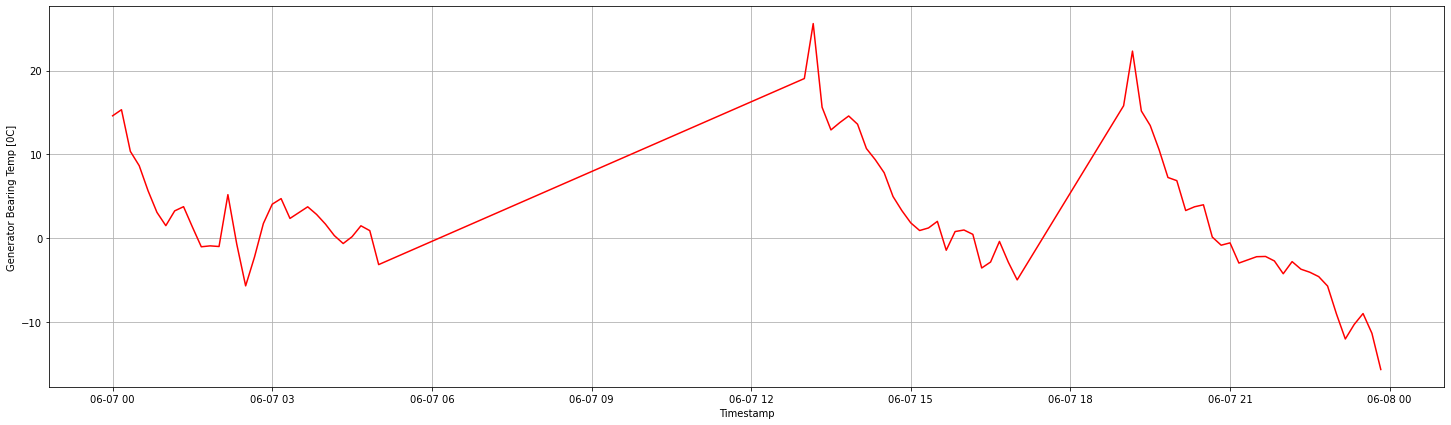

In [37]:
#First Failure(High Temperature): June 7th 2016 @ 5pm
plot_predicted_vs_true(predictions_1_1[(predictions_1_1.index.month == 6) & (predictions_1_1.index.day == 7)], 
                       Y_test_1_1[(Y_test_1_1.index.month == 6) & (Y_test_1_1.index.day == 7)], y_column)

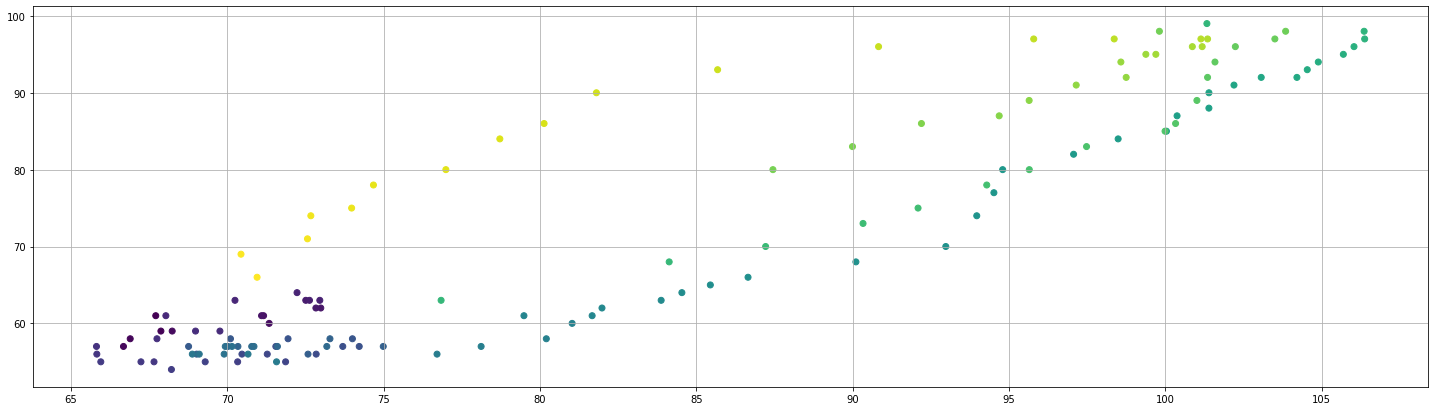

In [26]:
#Second Failure(High Temperature): August 22nd 2016 @ 6:25pm
plot_predicted_vs_true(predictions_1_1[(predictions_1_1.index.month == 8) & (predictions_1_1.index.day == 22)], 
                       Y_test_1_1[(Y_test_1_1.index.month == 8) & (Y_test_1_1.index.day == 22)], y_column)

Training model...
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 32)                256       
                                                                 
 dropout_16 (Dropout)        (None, 32)                0         
                                                                 
 dense_25 (Dense)            (None, 16)                528       
                                                                 
 dropout_17 (Dropout)        (None, 16)                0         
                                                                 
 dense_26 (Dense)            (None, 1)                 17        
                                                                 
Total params: 801
Trainable params: 801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
142/142 - 1s - loss: 0.1309

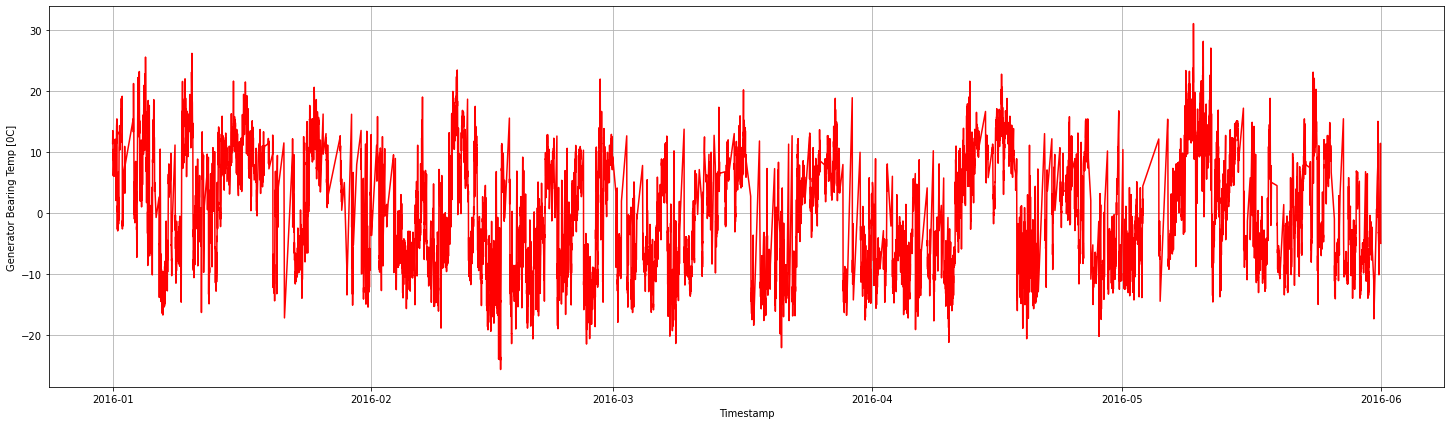

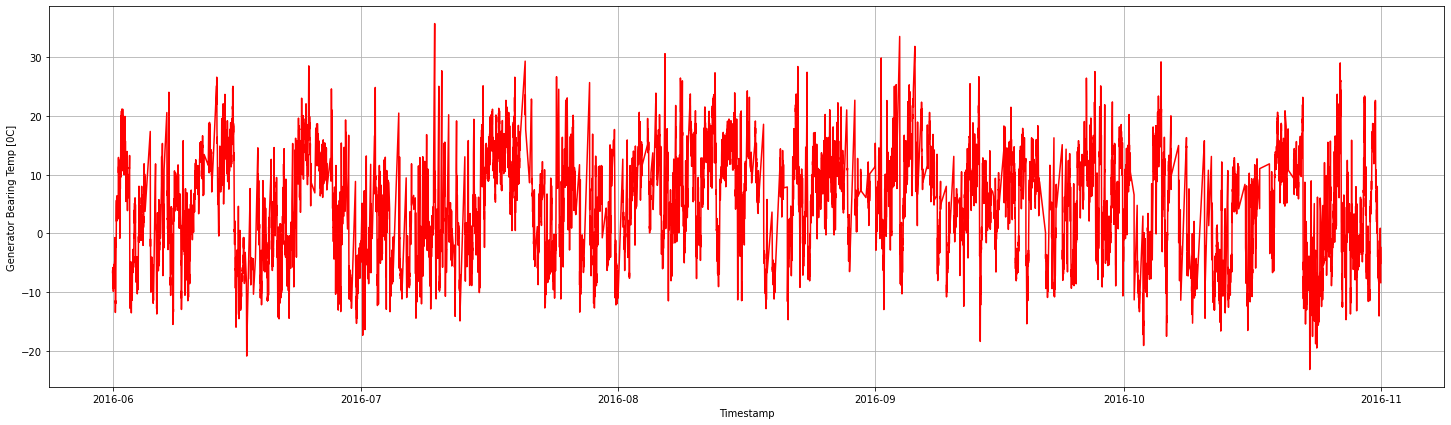

In [42]:
#Feature selection based on correlation matrix
features = ['Amb_WindSpeed_Avg', 'Cont_Top_Temp_Avg', 'Gear_Bear_Temp_Avg', 'Gear_Oil_Temp_Avg', 'Gen_RPM_Avg', 'Grd_Busbar_Temp_Avg',
                     'Prod_LatestAvg_TotReactPwr', 'Gen_Bear_Temp_Avg']

Y_test_1_2, predictions_1_2 = implement_pipeline(wtg_data, train_month_start=1, train_year_start=2016, train_month_end=5, train_year_end=2016,
                        test_month_start=6, test_year_start=2016, test_month_end=10, test_year_end=2016, y_column = y_column, features=features, epochs=20);

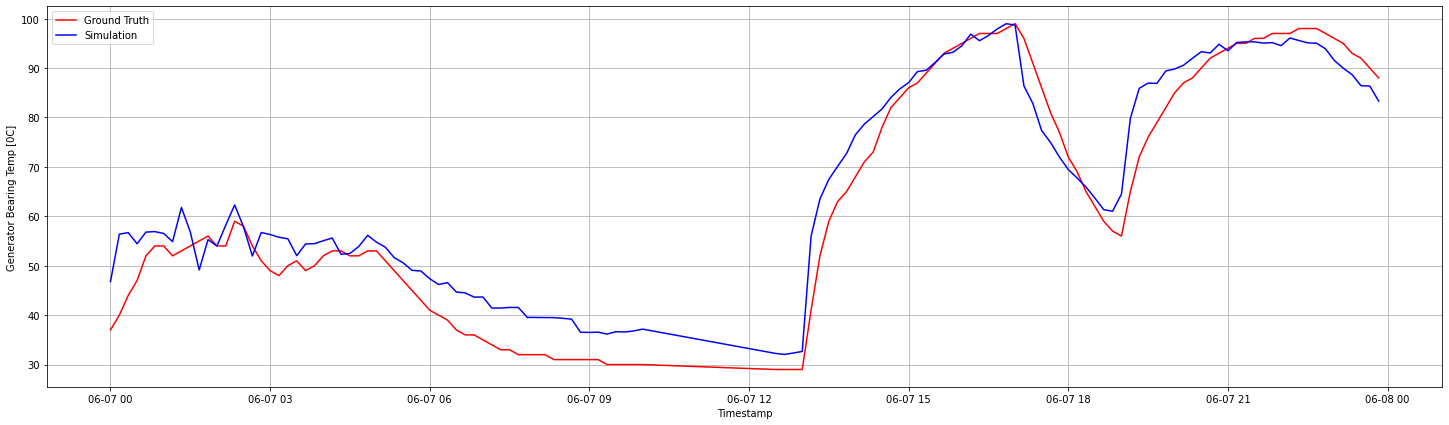

In [ ]:
#First Failure(High Temperature): June 7th 2016 @ 5pm
plot_predicted_vs_true(predictions_1_1[(predictions_1_2.index.month == 6) & (predictions_1_2.index.day == 7)], 
                       Y_test_1_2[(Y_test_1_2.index.month == 6) & (Y_test_1_2.index.day == 7)], y_column)

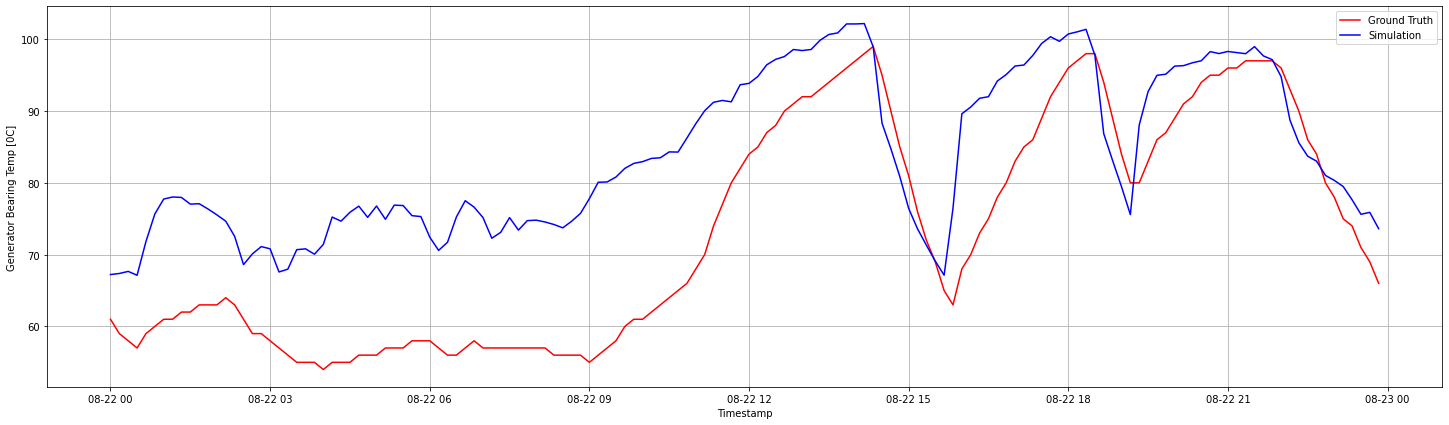

In [ ]:
#Second Failure(High Temperature): August 22nd 2016 @ 6:25pm
plot_predicted_vs_true(predictions_1_2[(predictions_1_2.index.month == 8) & (predictions_1_2.index.day == 22)], 
                       Y_test_1_2[(Y_test_1_2.index.month == 8) & (Y_test_1_2.index.day == 22)], y_column)

**Batch 2:** Further train model between November and December 2016, test for the whole year of 2017

Training model...
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 32)                256       
                                                                 
 dropout_28 (Dropout)        (None, 32)                0         
                                                                 
 dense_43 (Dense)            (None, 16)                528       
                                                                 
 dropout_29 (Dropout)        (None, 16)                0         
                                                                 
 dense_44 (Dense)            (None, 1)                 17        
                                                                 
Total params: 801
Trainable params: 801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
88/88 - 1s - loss: 0.2920 

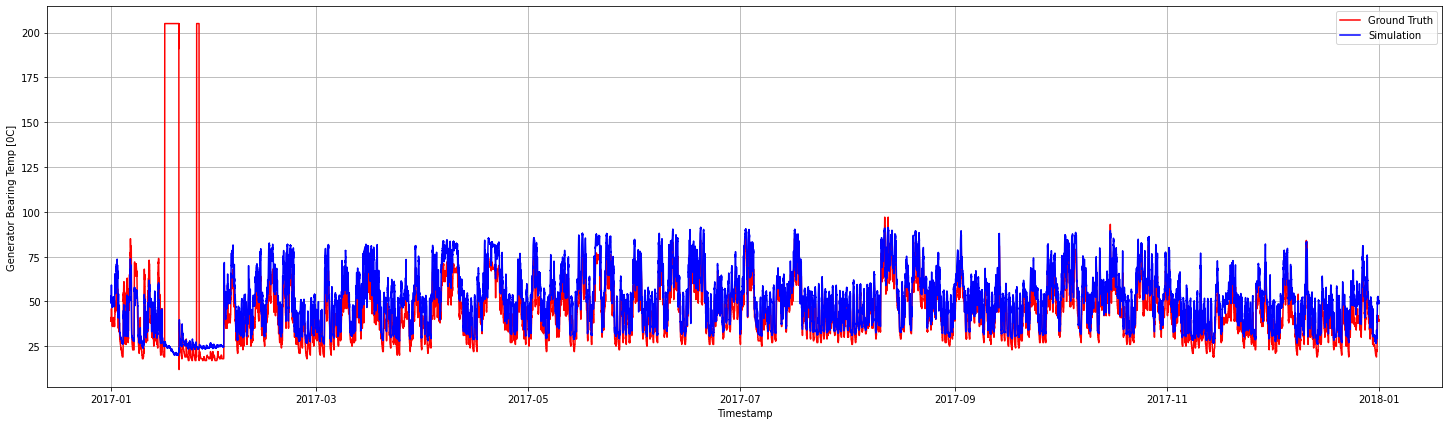

In [ ]:
#Feature selection based on causality
features = ['Nac_Temp_Avg', 'Amb_Temp_Avg', 'Gen_RPM_Avg', 'Gen_Phase1_Temp_Avg', 'Gen_Phase2_Temp_Avg', 'Gen_Phase3_Temp_Avg',
                     'Prod_LatestAvg_TotActPwr', 'Gen_Bear_Temp_Avg']

Y_test_2_1, predictions_2_1 = implement_pipeline(wtg_data, train_month_start=11, train_year_start=2016, train_month_end=12, train_year_end=2016,
                        test_month_start=1, test_year_start=2017, test_month_end=12, test_year_end=2017, y_column = y_column, features=features);

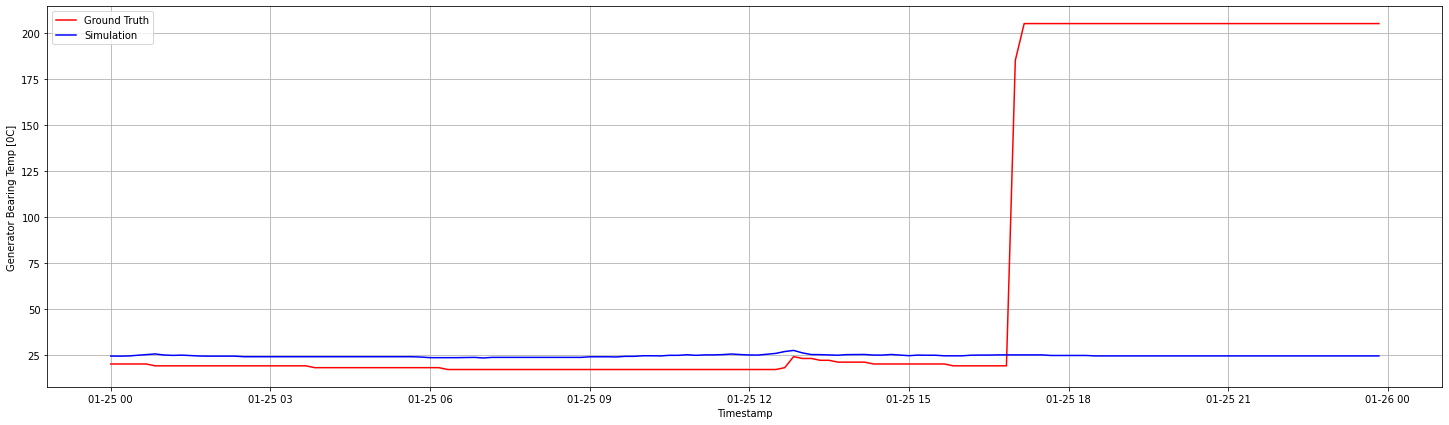

In [ ]:
#Failure(Bearing replaced): January 25th 2017 @ 13pm
plot_predicted_vs_true(predictions_2_1[(predictions_2_1.index.month == 1) & (predictions_2_1.index.day == 25)], 
                       Y_test_2_1[(Y_test_2_1.index.month == 1) & (Y_test_2_1.index.day == 25)], y_column)

Training model...
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_51 (Dense)            (None, 32)                256       
                                                                 
 dropout_34 (Dropout)        (None, 32)                0         
                                                                 
 dense_52 (Dense)            (None, 16)                528       
                                                                 
 dropout_35 (Dropout)        (None, 16)                0         
                                                                 
 dense_53 (Dense)            (None, 1)                 17        
                                                                 
Total params: 801
Trainable params: 801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
88/88 - 2s - loss: 0.1819 

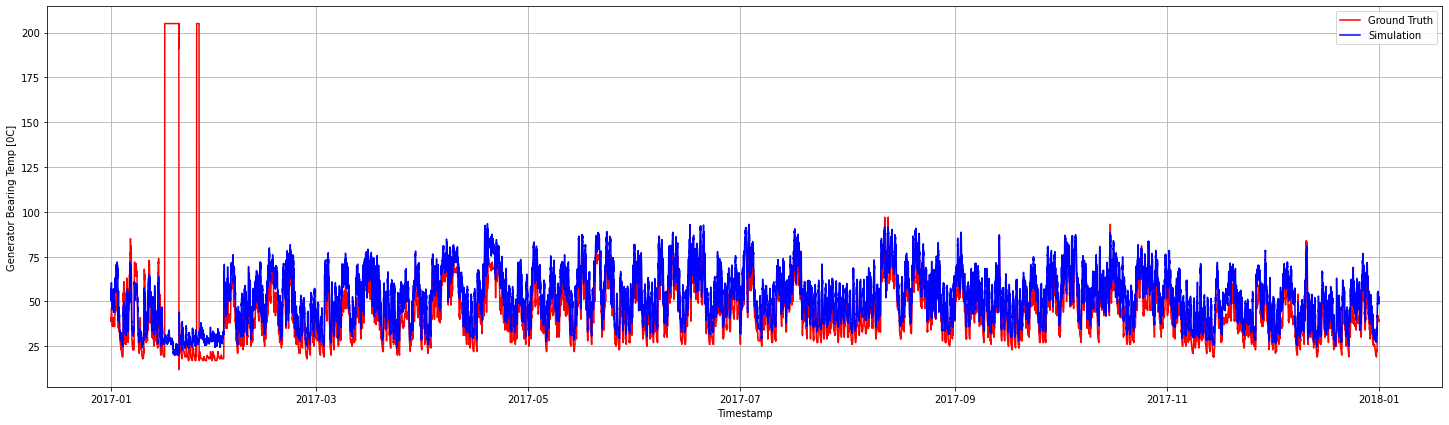

In [ ]:
#Feature selection based on correlation matrix
features = ['Amb_WindSpeed_Avg', 'Cont_Top_Temp_Avg', 'Gear_Bear_Temp_Avg', 'Gear_Oil_Temp_Avg', 'Gen_RPM_Avg', 'Grd_Busbar_Temp_Avg',
                     'Prod_LatestAvg_TotReactPwr', 'Gen_Bear_Temp_Avg']

Y_test_2_2, predictions_2_2 = implement_pipeline(wtg_data, train_month_start=11, train_year_start=2016, train_month_end=12, train_year_end=2016,
                        test_month_start=1, test_year_start=2017, test_month_end=12, test_year_end=2017, y_column = y_column, features=features);

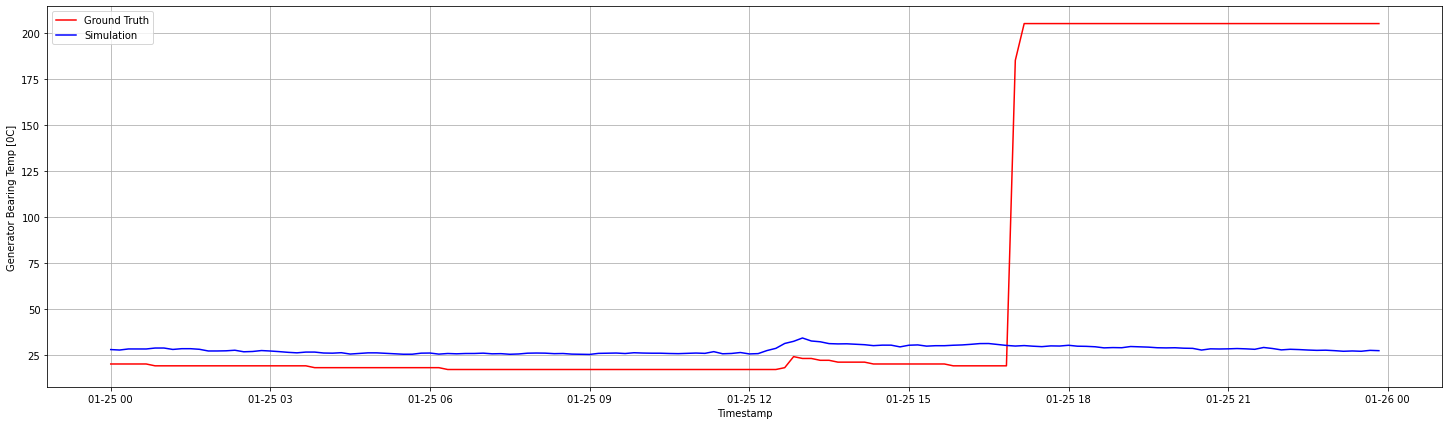

In [ ]:
#Failure(Bearing replaced): January 25th 2016 @ 13pm
plot_predicted_vs_true(predictions_2_2[(predictions_2_2.index.month == 1) & (predictions_2_2.index.day == 25)], 
                       Y_test_2_2[(Y_test_2_2.index.month == 1) & (Y_test_2_2.index.day == 25)], y_column)

**Batch 2:** Further train model between November and December 2016, test for the whole year of 2017

In [ ]:
#==================================================================================================================================================

#Reshape X_train and y_train to fit as LSTM input/output


timesteps = 1
X_normalized = np.array(X_normalized).reshape(X_normalized.shape[0] // timesteps, timesteps, X_normalized.shape[1])

In [ ]:
#Create model
batch_size = 100
model = Sequential([
          Input(shape = (X_normalized.shape[1], X_normalized.shape[2])),
          LSTM(32, stateful=False, recurrent_dropout= 0.3),
          Dropout(0.3),
          Dense(16),
          Dropout(0.3),
          Dense(Y_normalized.shape[1])
      ])
model.summary()

In [ ]:
#Compile model
model.compile(loss='mean_squared_error', optimizer='adam')

#Train model
model.fit(X_normalized, Y_normalized, epochs=10, batch_size = 100, verbose = 2, shuffle=False)

In [ ]:
#Load test data
signals_test = 'wind-farm-1-signals-testing.csv'
all_test_data = pd.read_csv(data_folder + signals_test, delimiter=';')

#Filter T_09 data out
wtg_test_data = all_test_data[all_test_data.Turbine_ID == 'T09'].reset_index().drop(columns=['index'])

wtg_test_data['Timestamp'] = pd.to_datetime(wtg_test_data['Timestamp'])

In [ ]:
#Select features
test_data = wtg_test_data[selected_features].set_index('Timestamp')

#Add lagged Gen_Bear_Temp_Avg
#test_data['Gen_Bear_Temp_Avg-1'] = test_data.shift(periods=1)['Gen_Bear_Temp_Avg']
#test_data['Gen_Bear_Temp_Avg-2'] = test_data.shift(periods=2)['Gen_Bear_Temp_Avg']

In [ ]:
#Drop rows with NaN values
test_data.dropna(inplace=True)

#Split data to X and Y
X_test = test_data.drop('Gen_Bear_Temp_Avg', axis=1)
Y_test = test_data[['Gen_Bear_Temp_Avg']]

#Normalize data
X_normalized_test = pd.DataFrame(scaler_input.transform(X_test), columns=X_test.columns, index=X_test.index)
Y_normalized_test = pd.DataFrame(scaler_target.transform(Y_test), columns=Y_test.columns, index= Y_test.index)

timesteps = 1
X_normalized_test = np.array(X_normalized_test).reshape(X_normalized_test.shape[0] // timesteps, timesteps, X_normalized_test.shape[1])

In [ ]:
model.evaluate(X_normalized_test, Y_normalized_test)

547/547 [==============================] - 1s 2ms/step - loss: 7.2216e-04


0.0007221567211672664

In [ ]:
predictions = scaler_target.inverse_transform(model.predict(X_normalized_test))

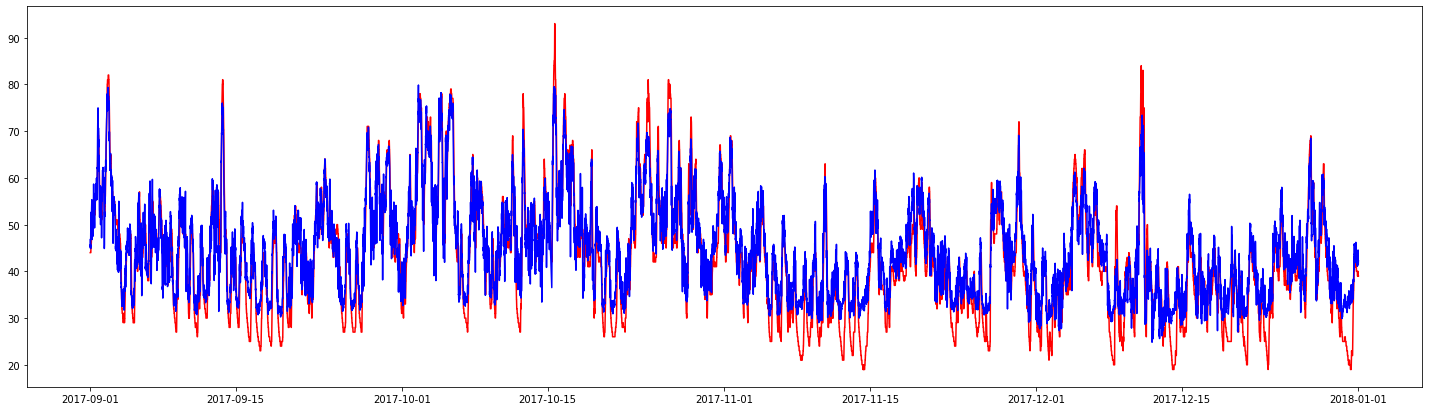

In [ ]:
fig, ax = plt.subplots(figsize=(25,7))
x = Y_test.index
ax.plot(x, Y_test['Gen_Bear_Temp_Avg'], color = 'red')
ax.plot(x, predictions, color = 'blue') 

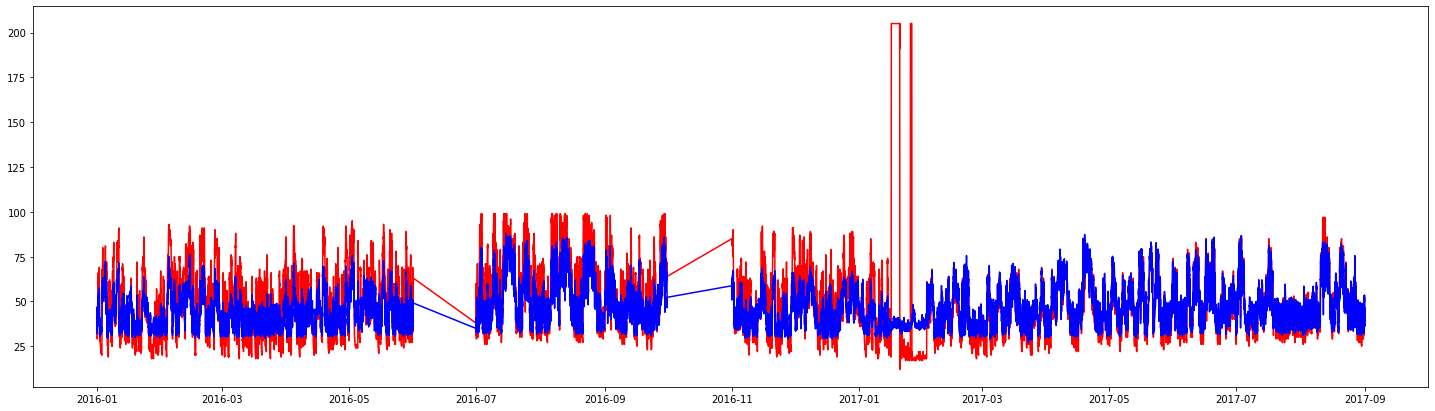

In [ ]:
predictions_train = scaler_target.inverse_transform(model.predict(X_normalized))
fig, ax = plt.subplots(figsize=(25,7))
x = Y.index
ax.plot(x, Y['Gen_Bear_Temp_Avg'], color = 'red')
ax.plot(x, predictions_train, color = 'blue') 

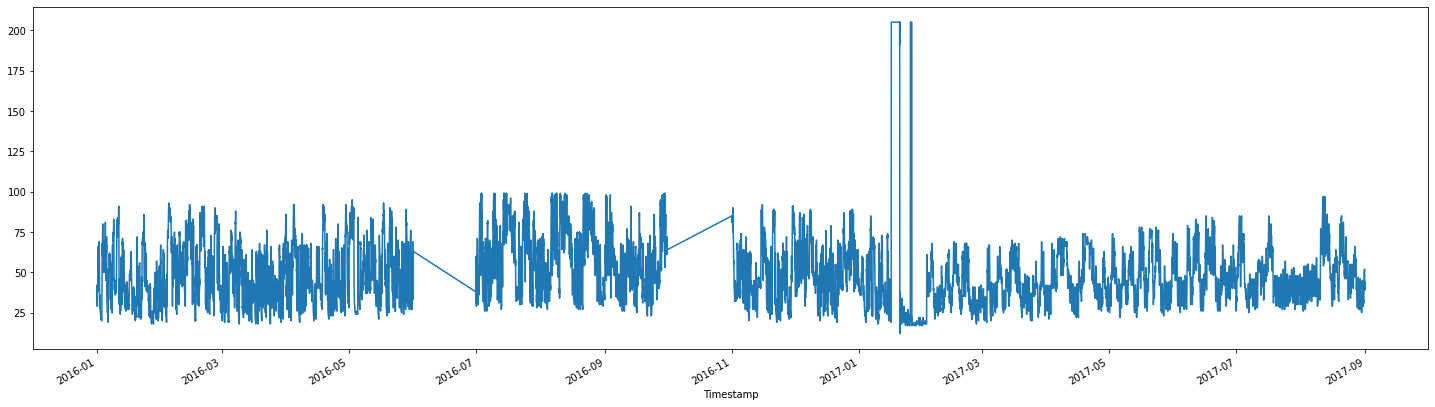

In [ ]:
train_data['Gen_Bear_Temp_Avg'].plot(figsize=(25,7))